<a href="https://colab.research.google.com/github/voquangtuong/Forecasting/blob/master/python_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install livelossplot --quiet

In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import os
os.chdir('/content/drive/MyDrive/forecasting_models-master')

In [51]:
df = pd.read_csv("percentile_101.csv")
df.head()

,Date,Andong106,Ansan75,Ansoeng76,Anyang77,Asan25,Boeun13,Bonghwa107,Boryeong26,Boseong186,Buan170,Buan171,Bucheon78,Buk0,Buk264,Buk41,Buk72,Bupyeong154,Busanjin1,Buyeo27,Changnyeong128,Changwon129,Changwon130,Cheonan28,Cheongdo108,Cheongju14,Cheongsong109,Cheongyang29,Cheorwon54,Chilgok110,Chuncheon55,Chungju15,Daedeok49,Dalseo42,Dalseong43,Damyang187,Dangjin30,Danyang16,Dobong240,Dong-daemun241,...,Wando224,Wando225,Wando226,Wando227,Wando228,Wando229,Wando230,Wando231,Wando232,Wanju185,Wonju68,Yangcheon261,Yanggu69,Yangju101,Yangpyeong102,Yangsan153,Yangyang70,Yecheon123,Yeoju103,Yeoncheon104,Yeongam233,Yeongcheon124,Yeongdeok125,Yeongdeungpo262,Yeongdo11,Yeongdong24,Yeonggwang234,Yeongi239,Yeongju126,Yeongwol71,Yeongyang127,Yeonje12,Yeosu235,Yeosu236,Yeosu237,Yeosu238,Yesan40,Yongin105,Yongsan263,Yuseong53
0,1/1/1981,-0.096065,-0.065309,-0.091778,-0.013643,-0.065237,-0.140959,-0.234833,-0.116645,-0.067931,-0.060226,-0.063709,-0.061529,-0.076276,0.054853,0.035113,0.111527,-0.277485,0.077219,-0.012811,-0.063924,-0.087005,0.081778,0.047243,-0.023145,0.047636,-0.079095,-0.262606,-0.263412,0.030470,-0.229430,-0.218418,-0.001771,-0.173986,-0.134963,-0.226888,-0.146896,-0.176443,-0.247202,-0.227949,...,-0.030088,0.162754,0.066939,0.130644,-0.255034,-0.097724,0.125686,0.111168,0.131144,0.094169,-0.160055,-0.163146,-0.171986,-0.193212,-0.175538,-0.130884,-0.173796,-0.211541,-0.128040,-0.155462,-0.229708,-0.165980,-0.179798,-0.179263,-0.152433,-0.177845,-0.155118,-0.241527,-0.178779,-0.177736,-0.178123,-0.180121,-0.142967,-0.173613,-0.183636,-0.345732,-0.319265,-0.349226,-0.340821,-0.319411
1,2/1/1981,-0.222752,-0.258344,-0.207390,-0.009399,-0.208115,-0.169015,-0.251329,-0.190957,-0.253510,-0.257562,-0.250981,-0.264221,-0.233281,-0.562902,0.087633,-0.140747,-0.552125,-0.105356,-0.280711,-0.316039,-0.257478,-0.045496,-0.041238,-0.288679,-0.122818,-0.315383,-0.778443,-0.113112,-0.368248,-0.130210,0.098107,-0.123622,-0.139982,-0.182470,-0.322975,-0.164397,-0.369369,0.299033,-0.375438,...,0.371257,0.542205,0.398728,0.477489,-0.128831,-0.329122,-0.123851,-0.114452,-0.372185,-0.364971,-0.254508,0.034217,0.034270,0.049305,0.019456,0.061011,0.021435,0.053753,0.065167,0.079788,0.080809,0.062392,0.010618,0.014464,0.051605,0.023274,0.042427,0.059783,0.014007,0.016296,0.033765,0.078904,0.066895,0.049858,0.021396,-0.532578,-0.435339,-0.547044,-0.517135,-0.442771
2,3/1/1981,-0.887354,-1.004016,-0.827809,-0.578719,-0.873661,-0.614425,-0.363034,-0.705959,-0.982379,-1.005825,-0.986975,-1.021996,-0.901035,-0.962445,0.518190,-0.682520,-0.573387,-0.360713,-0.481472,-0.403166,-0.216199,0.040735,-0.169070,-0.312442,-0.347891,-0.650520,-1.211557,-1.093079,-0.699389,-0.932779,-0.737120,0.622011,-0.573124,-0.026642,-0.886619,-0.511082,-0.809202,-0.860002,-0.887081,...,0.474276,-0.873890,0.071632,-0.549410,0.808380,0.363288,0.413080,0.559228,0.530901,0.527312,-0.330697,-0.333992,-0.335240,-0.294329,-0.375111,-0.230073,-0.369718,-0.285229,-0.238386,-0.194909,-0.209265,-0.257892,-0.398367,-0.388179,-0.283458,-0.364525,-0.309084,-0.268194,-0.389373,-0.383308,-0.337129,-0.220036,-0.234388,-0.290862,-0.369761,0.698675,0.677914,0.890032,0.761274,0.195061
3,4/1/1981,-0.293198,-0.336257,-0.266975,-0.101927,-0.285707,-0.179253,-0.079146,-0.217827,-0.327963,-0.336223,-0.329391,-0.342934,-0.297650,0.483461,0.501633,-0.960610,0.005503,-0.263598,-0.399157,-0.395832,0.273186,0.207477,-0.095438,-0.079067,-0.262122,-0.557459,-0.866120,-0.973870,-0.602466,-0.813713,-0.337480,-0.502733,-0.519012,-0.133241,-0.576220,-0.523349,-0.570342,-0.083440,-0.561125,...,0.006851,0.127535,0.069596,0.103236,-0.053065,-0.110695,-0.501579,-0.477797,-0.673146,-0.664719,-0.279319,-0.321905,-0.331484,-0.393305,-0.335459,-0.336650,-0.324168,-0.422055,-0.410072,-0.423852,-0.463270,-0.345314,-0.324102,-0.329189,-0.319929,-0.360543,-0.317363,-0.466045,-0.337370,-0.326568,-0.351010,-0.375694,-0.404164,-0.391097,-0.352830,0.258687,0.245637,0.275004,0.254202,0.157748
4,5/1/1981,0.900109,1.422329,1.089

# Data Preparation

For simplicity, we consider fixed length sequences at training time. We use the past 24 months to forecast the following 12 months.

In [52]:
# make consistency names
df=df.iloc[:,1:2]
df=df.rename(columns = {'Andong106': 'x'}, inplace = False)
# df.rename(columns = 'x', inplace = False)
# df

In [85]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 1, normalize = False):
    
    train_df = df[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.x.mean()
        sd = train_df.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.x[i:(i+length_train_sequence)].values)
        y.append(train_df.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

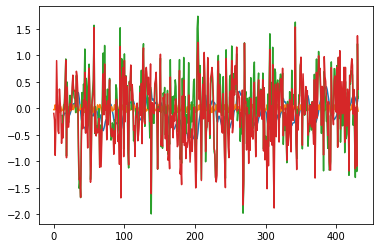

In [86]:
# a naive seasonal decomposition
series = df.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [87]:
deseasonalised_df = pd.DataFrame({'x':result.trend[12:]+result.resid[12:]})
deseasonalised_df.head()

,x
0,-0.275259
1,-0.533485
2,-0.133268
3,0.033130
4,0.374438


In [88]:
# build both versions
des_train_x,des_train_y,des_test_x, _ = train_test_builder(deseasonalised_df)
train_x,train_y,test_x,test_y = train_test_builder(df)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((372, 24, 1), (372, 12), (25, 24, 1), (25, 12))

# Evaluation

In [89]:
# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

# LSTM 

In [111]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
K.clear_session()
number_units0=300
number_epochs0=100
number_batch0=16
learing_rate0=0.001
# activation_function0='custom_activation'
activation_function0='linear'
# activation_function0='LeakyReLU'
dropout0=0.2
patience0=100
optimizer_function0=optimizers.Adam(learing_rate0)
loss='mse'
# define model
model = Sequential()
model.add(LSTM(number_units0, activation=activation_function0, input_shape=(None, 1),return_sequences=True))
model.add(LSTM(number_units0, activation=activation_function0, input_shape=(None, 1),return_sequences=True))
model.add(LSTM(number_units0, activation=activation_function0, input_shape=(None, 1),return_sequences=True))
model.add(LSTM(number_units0, activation=activation_function0, input_shape=(None, 1)))
model.add(Dropout(dropout0))
model.add(Dense(128, activation=activation_function0))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))
model.summary()
# compile
model.compile(loss='mse', optimizer= optimizer_function0, metrics = ["mse"])

# callbacks
early_stopping = EarlyStopping(patience=patience0, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]
# callbacks_stop = [EarlyStopping(monitor='val_loss', patience=patience0)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 300)         362400    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 300)         721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 300)         721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

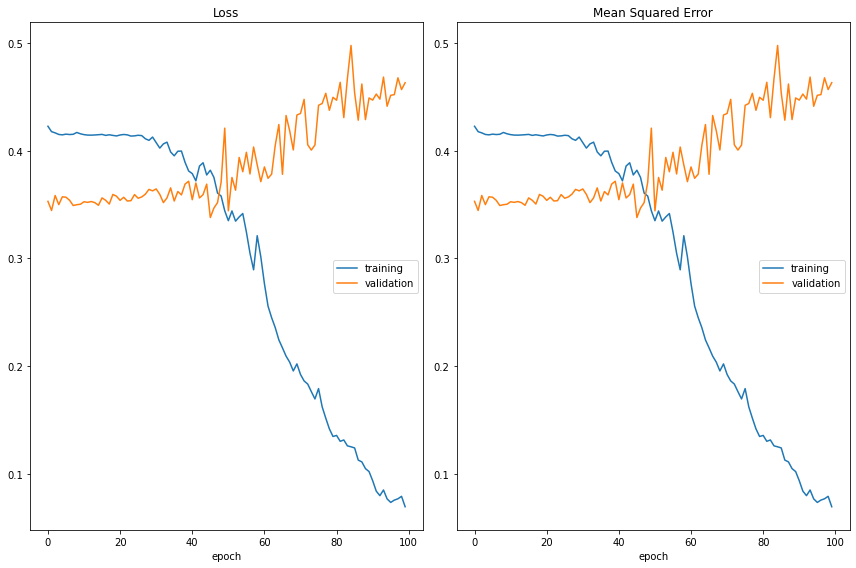

Loss
	training         	 (min:    0.070, max:    0.423, cur:    0.070)
	validation       	 (min:    0.338, max:    0.498, cur:    0.463)
Mean Squared Error
	training         	 (min:    0.070, max:    0.423, cur:    0.070)
	validation       	 (min:    0.338, max:    0.498, cur:    0.463)


In [112]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.2, 
          epochs=number_epochs0, 
          shuffle = True,
          batch_size=number_batch0,
          verbose=1,
          callbacks = callbacks,
         )

In [113]:
# predict test set
pred_y = model.predict(des_test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

Mean absolute error test set: 0.6632237155461557


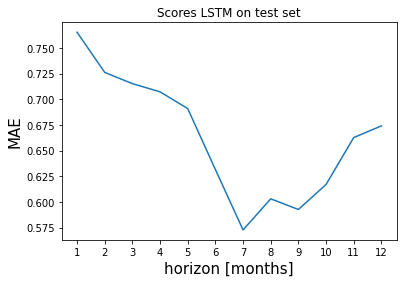

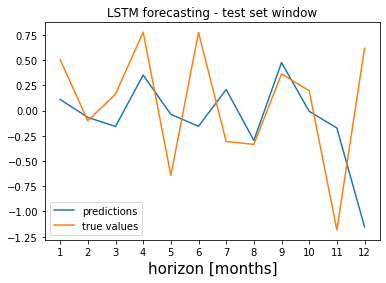

In [114]:
plot_evaluation(pred_y,test_y,n=12)

In [94]:
# store predictions on test set
tmp = pd.DataFrame(test_y-pred_y)
tmp.columns = np.arange(1,13)

tmp.to_csv("lstm_predictions.csv",index = False)

# Encoder Decoder

In [95]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

des_train_y = des_train_y.reshape((des_train_y.shape[0], des_train_y.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.1))
model.add(RepeatVector(n_outputs))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(1)))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=16, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


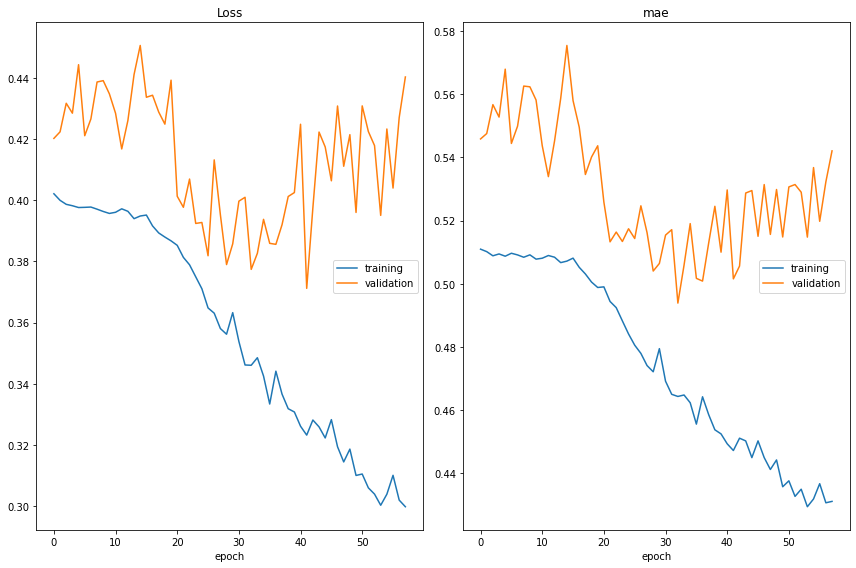

Loss
	training         	 (min:    0.300, max:    0.402, cur:    0.300)
	validation       	 (min:    0.371, max:    0.451, cur:    0.440)
mae
	training         	 (min:    0.429, max:    0.511, cur:    0.431)
	validation       	 (min:    0.494, max:    0.575, cur:    0.542)


In [96]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.1, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 0.6139493008421967


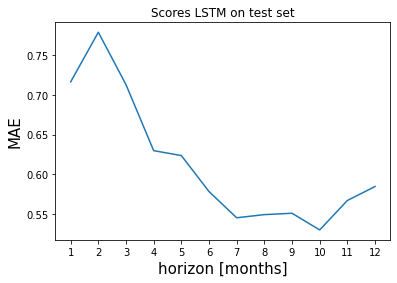

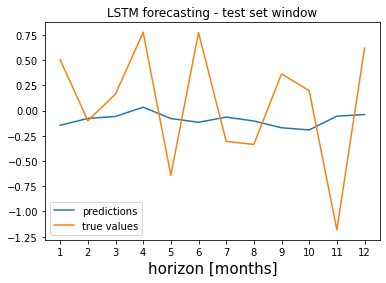

In [97]:
# predict test set
pred_y = model.predict(des_test_x).reshape(-1,12)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)

# Encoder decoder CNN LSTM

In [98]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

des_train_y = des_train_y.reshape((des_train_y.shape[0], des_train_y.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(1)))
# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=16, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


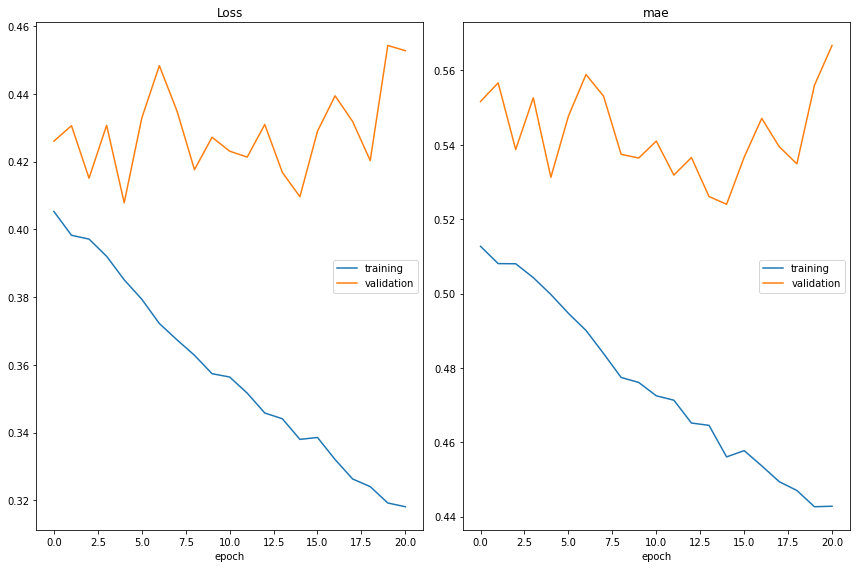

Loss
	training         	 (min:    0.318, max:    0.405, cur:    0.318)
	validation       	 (min:    0.408, max:    0.454, cur:    0.453)
mae
	training         	 (min:    0.443, max:    0.513, cur:    0.443)
	validation       	 (min:    0.524, max:    0.567, cur:    0.567)


In [99]:
# fit network
model.fit(des_train_x, des_train_y, 
          validation_split = 0.1, 
          epochs=100, 
          shuffle = True,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 0.5671946738010308


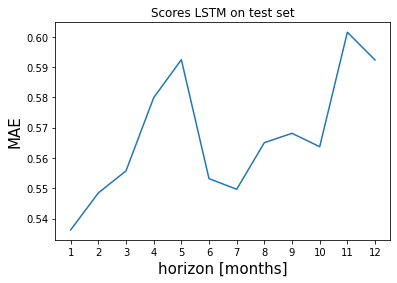

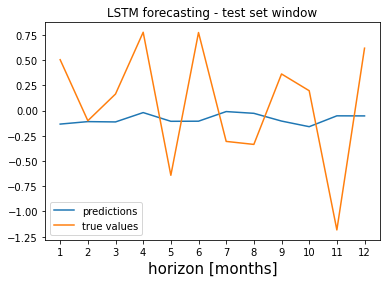

In [100]:
# predict test set
pred_y = model.predict(des_test_x).reshape(-1,12)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)